In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from Melt_Viscosity_Predictor.utils.metrics import OME, MSE, get_CV_error
import tensorflow as tf
from scipy.stats import gaussian_kde
import scipy.spatial as spatial

In [3]:
models_list = os.listdir('./MODELS')

In [4]:
poly_splits = [model for model in models_list if 'polysplitnew' in model and 'LC' not in model and 't2' in model]

In [5]:
poly_splits[0][:10]
poly_splits[0][11:]

'polysplitnew_poly(decamethylene succinate)_t2'

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-04-07 12:14:29.806038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 12:14:30.946168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28818 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:da:00.0, compute capability: 7.0


In [7]:
full_data = pd.read_excel('Data/full_data_03_08_aug_MOD.xlsx')
full_data['Polymer'].replace(r'[\W]','',inplace=True,regex=True)

In [19]:
id = 0
test_results = pd.DataFrame()
print('polysplits',len(poly_splits))
for p in poly_splits:
    if ('2022-12-05' in p or '2022-12-06' in p or 'hdpe' in p):
        print(p)
        continue
    try:
        split_df = pd.read_pickle('./MODELS/' + p + '/test_evals.pkl')
    except:
        #print(f'Error in reading results for {p}')
        continue
        id += 1
    split_df = split_df[['Polymer','Mw', 'Temperature', 'Shear_Rate', 'PDI', 'ANN_Pred', 'ANN_Pred_var', 'HyperNet_Pred', 'HyperNet_Pred_var', 'GPR_Pred', 'GPR_Pred_var','Melt_Viscosity']].reset_index(drop=True)
    test_results = pd.concat([test_results, split_df])
    if 'methacrylate' in p:
        print(p, test_results.shape)
print(id)

polysplits 110
2022-12-29_polysplitnew_0_poly(sodium methacrylate)_t2 (784, 12)
2022-12-12_polysplitnew_poly(methyl methacrylate)_t2 (938, 12)
0


In [20]:
test_results.shape

(2305, 12)

In [21]:
test_results = test_results.drop_duplicates().dropna().reset_index(drop = True)

In [22]:
test_results = test_results.dropna()

In [23]:
#Filter Outliers
test_results = test_results.loc[test_results['HyperNet_Pred'] > -3]
test_results = test_results.loc[test_results['GPR_Pred'] > -3]
test_results = test_results.loc[test_results['ANN_Pred'] > -3]
test_results['Mw'] = np.power(test_results['Mw'],10)

In [24]:
test_results.loc[test_results['HyperNet_Pred'] < -3]

,Polymer,Mw,Temperature,Shear_Rate,PDI,ANN_Pred,ANN_Pred_var,HyperNet_Pred,HyperNet_Pred_var,GPR_Pred,GPR_Pred_var,Melt_Viscosity


In [25]:
def missing_samples(split, full):
    split = set(split['Polymer'].unique())
    if 'polystyrene' in split:
        print('polystyrene exists')
    full = set(full['Polymer'].unique())
    #print(split.head(20))
    #print(full)
    #i1 = pd.MultiIndex.from_frame(split)
    #print(i1)
    #i2 = pd.MultiIndex.from_frame(full)
    return (list(full.difference(split)))

In [26]:
test_results.shape

(2118, 12)

Text(10.75, -2.5, '(C)')

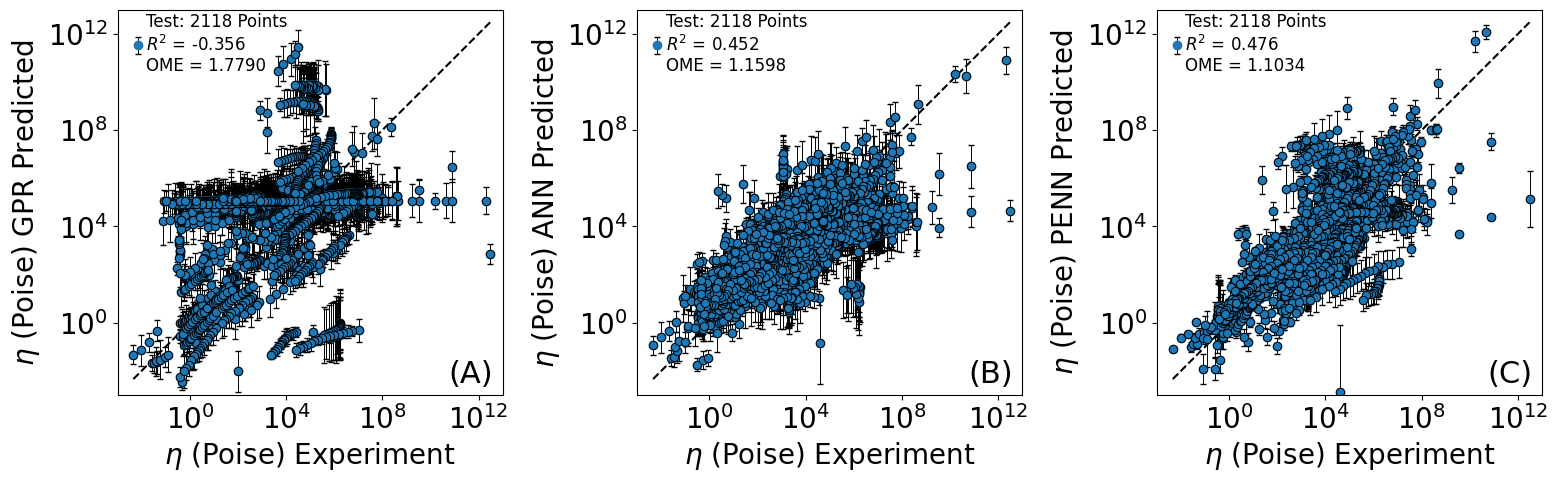

In [56]:
#ANN Plot
ax_ft = 20
fig = plt.figure(figsize = (19,5))
fig.tight_layout(pad = 5)
ax2 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
#ax2, ax1, ax3 = plt.subplot(1,3,1), plt.subplot(1,3,2), plt.subplot(1,3,3)

y_test =np.array(test_results['Melt_Viscosity'])
test_pred = np.array(test_results['ANN_Pred'])
test_var = np.array(test_results['ANN_Pred_var'])

ebar_args = {'ecolor': 'k', 'elinewidth': 0.7, 'capsize':2, 'zorder':1}
point_args = {'edgecolors': 'k', 'linewidths':0.7, 'zorder':2}

#ax1.errorbar(yy, list(train_pred.reshape(-1,)), yerr = list(np.array(train_var).reshape(-1,)), c = 'orange', fmt = 'o', label = f'Train: {train_pred.shape[0]} Points') 
#+ r'$R^2$ = ' + "{:1.3f}, ".format(r2_score(yy, train_pred)) + "OME = {:1.4f}".format(get_CV_error(NN_cv, scaler= y_scaler)))

ax1.errorbar(y_test , list(test_pred.reshape(-1,)), yerr= list(np.array(test_var).reshape(-1,)), fmt =  'o', label = f'Test: {test_pred.shape[0]} Points\n' 
+ r'$R^2$ = ' + "{:1.3f}".format(r2_score(y_test, test_pred)) + "\nOME = {:1.4f}".format(OME(y_test, test_pred)), **ebar_args )
ax1.scatter(y_test , list(test_pred.reshape(-1,)), **point_args)
ax1.plot(np.linspace((min(y_test)), (max(y_test)), num = 2),np.linspace((min(y_test)), (max(y_test)), num = 2),'k--', zorder = 0)
ax1.set_ylabel(r'$\eta$ (Poise) ANN Predicted', fontsize = ax_ft)
ax1.set_xlabel(r'$\eta$ (Poise) Experiment', fontsize = ax_ft)
ax1.legend(loc = 'upper left', frameon = False, prop={"size":12}, handletextpad = -0.5, borderpad=-0.7, borderaxespad  = 0.9)
#plt.title('ANN Parity Plot')
ax1.set_xlim(-3, 13)
ax1.set_ylim(-3, 13)

ax1.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = ax_ft)
ax1.set_xticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = ax_ft)
#ax1.set_yticks(list(np.arange(-2,13,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$', r'$10^{12}$'])
#ax1.set_xticks(list(np.arange(-2,13,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$', r'$10^{12}$'])

#plt.gca().set_aspect('equal', adjustable='box')
ax1.set_box_aspect(1)


#GPR Plot
test_pred, var = np.array(test_results['GPR_Pred']), np.array(test_results['GPR_Pred_var'])
#train_pred, var_train = np.array(train_results['GPR_Pred']), np.array(train_results['GPR_Pred_var'])

test_pred = test_pred.reshape(-1,1)

high_var = np.argmax(y_test - test_pred, 0)
test_pred = np.delete(test_pred,high_var)
y_test_gpr = np.delete(y_test,high_var)
test_var= np.delete(test_var,high_var)

ax2.errorbar(y_test_gpr , list(test_pred.reshape(-1,)), yerr= list(np.array(test_var).reshape(-1,)), fmt =  'o', label = f'Test: {test_pred.shape[0] + 1} Points\n' 
+ r'$R^2$ = ' + "{:1.3f}".format(r2_score(y_test_gpr, test_pred)) + "\nOME = {:1.4f}".format(OME(y_test_gpr, test_pred)), **ebar_args )
ax2.scatter(y_test_gpr , list(test_pred.reshape(-1,)), **point_args)
# test_pred = np.array(test_results['HyperNet_Pred'])
# test_var = np.array(test_results['HyperNet_Pred_var'])

# #+ r'$R^2$ = ' + "{:1.3f}, ".format(r2_score(yy, train_pred)) + "OME = {:1.4f}".format(get_CV_error(NN_cv, scaler= y_scaler)))

# ax2.errorbar(y_test , list(test_pred.reshape(-1,)), yerr= list(np.array(test_var).reshape(-1,)), fmt =  'o', label = f'Test: {test_pred.shape[0]} Points\n' 
# + r'$R^2$ = ' + "{:1.3f}".format(r2_score(y_test, test_pred)) + "\nOME = {:1.4f}".format(OME(y_test, test_pred)))



ax2.plot(np.linspace((min(y_test)), (max(y_test)), num = 2),np.linspace((min(y_test)), (max(y_test)), num = 2),'k--', zorder = 0)
ax2.set_ylabel(r'$\eta$ (Poise) GPR Predicted', fontsize = ax_ft)
ax2.set_xlabel(r'$\eta$ (Poise) Experiment', fontsize = ax_ft)
ax2.legend(loc = 'upper left', frameon = False, prop={"size":12}, handletextpad = -0.5, borderpad=-0.7, borderaxespad  = 0.9)
#ax2.title('GPR Parity Plot')
ax2.set_xlim(-3, 13)
ax2.set_ylim(-3, 13)
ax2.set_box_aspect(1)

# ax2.set_yticks(list(np.arange(-2,13,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$', r'$10^{12}$'])
# ax2.set_xticks(list(np.arange(-2,13,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$', r'$10^{12}$'])
ax2.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = ax_ft)
ax2.set_xticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = ax_ft)


#HypNet

test_pred = np.array(test_results['HyperNet_Pred'])
test_var = np.array(test_results['HyperNet_Pred_var'])

#+ r'$R^2$ = ' + "{:1.3f}, ".format(r2_score(yy, train_pred)) + "OME = {:1.4f}".format(get_CV_error(NN_cv, scaler= y_scaler)))

ax3.errorbar(y_test , list(test_pred.reshape(-1,)), yerr= list(np.array(test_var).reshape(-1,)), fmt =  'o', label = f'Test: {test_pred.shape[0]} Points\n' 
+ r'$R^2$ = ' + "{:1.3f}".format(r2_score(y_test, test_pred)) + "\nOME = {:1.4f}".format(OME(y_test, test_pred)), **ebar_args )
ax3.scatter(y_test , list(test_pred.reshape(-1,)), **point_args)

ax3.plot(np.linspace((min(y_test)), (max(y_test)), num = 2),np.linspace((min(y_test)), (max(y_test)), num = 2),'k--', zorder = 0)
ax3.set_ylabel(r'$\eta$ (Poise) PENN Predicted', fontsize = ax_ft)
ax3.set_xlabel(r'$\eta$ (Poise) Experiment', fontsize = ax_ft)
ax3.legend(loc = 'upper left', frameon = False, prop={"size":12}, handletextpad = -0.5, borderpad=-0.7, borderaxespad  = 0.9)
#plt.title('ANN Parity Plot')
ax3.set_xlim(-3, 13)
ax3.set_ylim(-3, 13)

ax3.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = ax_ft)
ax3.set_xticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = ax_ft)
ax3.set_box_aspect(1)

ax1.annotate('(B)', (10.75,-2.5), fontsize = ax_ft +2)
ax2.annotate('(A)', (10.75,-2.5), fontsize = ax_ft + 2)
ax3.annotate('(C)', (10.75,-2.5), fontsize = ax_ft + 2)
#plt.gca().set_aspect('equal', adjustable='box')

#plt.savefig('Paper_Fig/parity_plots_new.pdf', dpi=300, bbox_inches="tight")
#plt.savefig('../../../data/ayush/Melt_Viscosity_Predictor/parity_poly_split.svg', dpi=300, bbox_inches="tight")


(2118,)
(2118,)
(2118,)
(2118,)


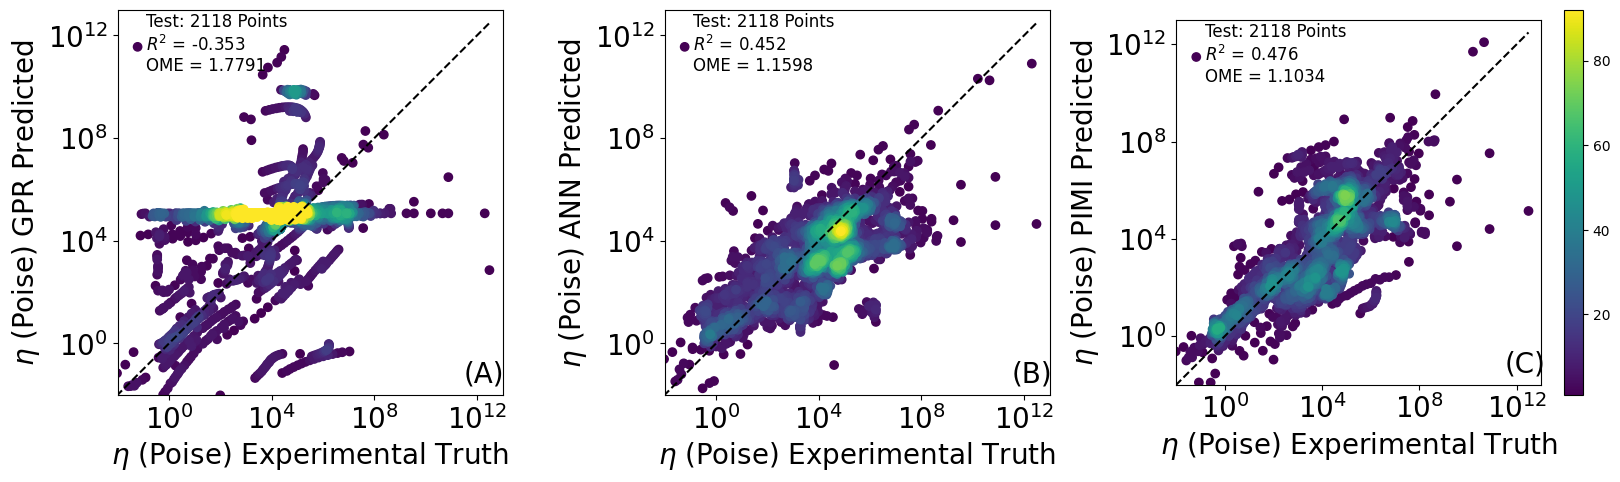

In [55]:
#PLOT WITH DENSITY
#ANN Plot
ax_ft = 20
fig = plt.figure(figsize = (20,5))
fig.tight_layout(pad = 5)
ax2 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

y_test =np.array(test_results['Melt_Viscosity'])
test_pred = np.array(test_results['ANN_Pred'])
test_var = np.array(test_results['ANN_Pred_var'])

points = np.array([(p, a) for p,a in zip(test_results['Melt_Viscosity'], test_results['ANN_Pred'])])
tree = spatial.KDTree(np.array(points))
radius = 0.3

neighbors = tree.query_ball_tree(tree, radius)
neighbors = np.array([len(l) for l in neighbors])
order = np.argsort(neighbors)
vmin = min(neighbors)
vmax = max(neighbors)
#scat1 = ax1.scatter(y_test , list(test_pred.reshape(-1,)), c = density)

ax1.scatter(y_test[order] , list(test_pred.reshape(-1,)[order]),label = f'Test: {test_pred.shape[0]} Points\n' 
+ r'$R^2$ = ' + "{:1.3f}".format(r2_score(y_test, test_pred)) + "\nOME = {:1.4f}".format(OME(y_test, test_pred)), c= neighbors[order], vmin = vmin, vmax = vmax)

ax1.plot(np.linspace((min(y_test)), (max(y_test)), num = 2),np.linspace((min(y_test)), (max(y_test)), num = 2),'k--', zorder = 10)
ax1.set_ylabel(r'$\eta$ (Poise) ANN Predicted', fontsize = ax_ft)
ax1.set_xlabel(r'$\eta$ (Poise) Experiment', fontsize = ax_ft)
ax1.legend(loc = 'upper left', frameon = False, prop={"size":12}, handletextpad = -0.5, borderpad=-0.7, borderaxespad  = 0.9)
#plt.title('ANN Parity Plot')
ax1.set_xlim(-2, 13)
ax1.set_ylim(-2, 13)
ax1.annotate('(B)', (11.5,-1.5), fontsize = ax_ft)
ax1.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = ax_ft)
ax1.set_xticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = ax_ft)
#ax1.set_yticks(list(np.arange(-2,13,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$', r'$10^{12}$'])
#ax1.set_xticks(list(np.arange(-2,13,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$', r'$10^{12}$'])


#plt.gca().set_aspect('equal', adjustable='box')
ax1.set_box_aspect(1)


#GPR Plot
test_pred, var = np.array(test_results['GPR_Pred']), np.array(test_results['GPR_Pred_var'])
#train_pred, var_train = np.array(train_results['GPR_Pred']), np.array(train_results['GPR_Pred_var'])

test_pred = test_pred.reshape(-1,1)

high_var = np.argmax(y_test - test_pred, 0)
test_pred = np.delete(test_pred,high_var)
y_test_gpr = np.delete(y_test,high_var)
test_var= np.delete(test_var,high_var)

test_pred = np.array(test_results['GPR_Pred'])
test_var = np.array(test_results['GPR_Pred_var'])

points = np.array([(p, a) for p,a in zip(test_results['Melt_Viscosity'], test_results['GPR_Pred'])])
tree = spatial.KDTree(np.array(points))

neighbors = tree.query_ball_tree(tree, radius)
neighbors = np.array([len(l) for l in neighbors])
#neighbors = np.array(neighbors) / max(neighbors)
order = np.argsort(neighbors)

print(y_test.shape)
print(test_pred.shape)
print(neighbors.shape)
print(order.shape)

ax2.scatter(y_test[order], list(test_pred.reshape(-1,)[order]), label = f'Test: {test_pred.shape[0]} Points\n' 
+ r'$R^2$ = ' + "{:1.3f}".format(r2_score((y_test), test_pred)) + "\nOME = {:1.4f}".format(OME(y_test, test_pred)), c= neighbors[order], vmin = vmin, vmax = vmax)
ax2.plot(np.linspace((min(y_test)), (max(y_test)), num = 2),np.linspace((min(y_test)), (max(y_test)), num = 2),'k--', zorder = 10)

ax2.set_ylabel(r'$\eta$ (Poise) GPR Predicted', fontsize = ax_ft)
ax2.set_xlabel(r'$\eta$ (Poise) Experiment', fontsize = ax_ft)
ax2.legend(loc = 'upper left', frameon = False, prop={"size":12}, handletextpad = -0.5, borderpad=-0.7, borderaxespad  = 0.9)
#ax2.title('GPR Parity Plot')
ax2.set_xlim(-2, 13)
ax2.set_ylim(-2, 13)
ax2.set_box_aspect(1)
ax2.annotate('(A)', (11.5,-1.5), fontsize = ax_ft)
# ax2.set_yticks(list(np.arange(-2,13,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$', r'$10^{12}$'])
# ax2.set_xticks(list(np.arange(-2,13,2)), [r'$10^{-2}$'] + [rf'$10^{i}$' for i in list(np.arange(0,9,2))] + [r'$10^{10}$', r'$10^{12}$'])
ax2.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = ax_ft)
ax2.set_xticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = ax_ft)

#HypNet

test_pred = np.array(test_results['HyperNet_Pred'])
test_var = np.array(test_results['HyperNet_Pred_var'])

#+ r'$R^2$ = ' + "{:1.3f}, ".format(r2_score(yy, train_pred)) + "OME = {:1.4f}".format(get_CV_error(NN_cv, scaler= y_scaler)))

points = np.array([(p, a) for p,a in zip(test_results['Melt_Viscosity'], test_results['HyperNet_Pred'])])
tree = spatial.KDTree(np.array(points))

neighbors = tree.query_ball_tree(tree, radius)
neighbors = np.array([len(l) for l in neighbors])
order = np.argsort(neighbors)


scat = ax3.scatter(y_test[order] , list(test_pred.reshape(-1,)[order]), label = f'Test: {test_pred.shape[0]} Points\n' 
+ r'$R^2$ = ' + "{:1.3f}".format(r2_score(y_test, test_pred)) + "\nOME = {:1.4f}".format(OME(y_test, test_pred)), c = neighbors[order], vmin = vmin, vmax = vmax)

ax3.plot(np.linspace((min(y_test)), (max(y_test)), num = 2),np.linspace((min(y_test)), (max(y_test)), num = 2),'k--', zorder = 10)
ax3.set_ylabel(r'$\eta$ (Poise) PIMI Predicted', fontsize = ax_ft)
ax3.set_xlabel(r'$\eta$ (Poise) Experiment', fontsize = ax_ft)
ax3.legend(loc = 'upper left', frameon = False, prop={"size":12}, handletextpad = -0.5, borderpad=-0.7, borderaxespad  = 0.9)
#plt.title('ANN Parity Plot')
ax3.set_xlim(-2, 13)
ax3.set_ylim(-2, 13)
ax3.annotate('(C)', (11.5,-1.5), fontsize = ax_ft)
ax3.set_yticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = 20)
ax3.set_xticks(list(np.arange(0,13,4)), [rf'$10^{i}$' for i in list(np.arange(0,9,4))] + [r'$10^{12}$'], fontsize = 20)
ax3.set_box_aspect(1)

#plt.colorbar()
plt.colorbar(scat)

#plt.gca().set_aspect('equal', adjustable='box')

#plt.savefig('Paper_Fig/parity_plots_new.pdf', dpi=300, bbox_inches="tight")
#plt.savefig('../../../data/ayush/Melt_Viscosity_Predictor/parity_poly_split.svg', dpi=300, bbox_inches="tight")
